# BOX-INPUT


In [1]:
import openmc
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import kdsource as kds
from mpl_toolkits.mplot3d import Axes3D as ax


#### Biblioteca de secciones eficaces

In [2]:
openmc_data = "/home/agusgimenez/Desktop/Secciones/endfb-viii.0-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

### MATERIALES

In [3]:
mat01 = openmc.Material(material_id=0) #agua
mat01.add_nuclide('H1',2.000,'ao')
mat01.add_nuclide('O16',0.9976,'ao')
mat01.add_nuclide('O17',0.00035,'ao')
mat01.add_s_alpha_beta('c_H_in_H2O')
mat01.set_density('g/cm3',1.00)

### PARAMETROS DE GEOMETRIAS


In [4]:

#bloque mat01
alpha =5.0 #escaleo del largo
L = 5.0 #semi-alto-ancho

#FUENTE
R = 1.0



### GEOMETRIAS


<Axes: xlabel='x [cm]', ylabel='z [cm]'>

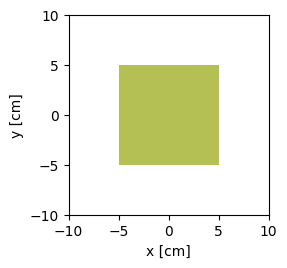

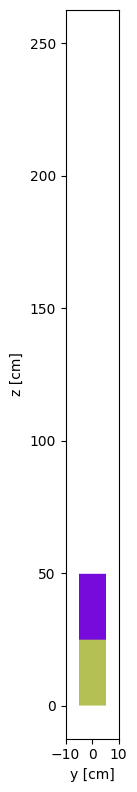

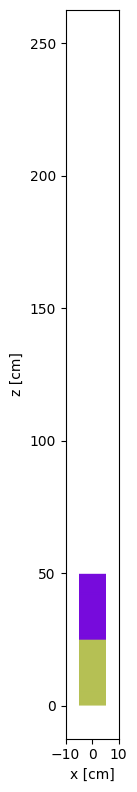

In [5]:

#bloque mat01
surf1 = openmc.XPlane(-L)
surf1.boundary_type = 'vacuum'

surf6 = openmc.XPlane(L)
surf6.boundary_type = 'vacuum'

surf2 = openmc.YPlane(-L)
surf2.boundary_type = 'vacuum'

surf5 = openmc.YPlane(L)
surf5.boundary_type = 'vacuum'


surf3 = openmc.ZPlane(0)
surf3.boundary_type = 'vacuum'

surf7 = openmc.ZPlane(alpha*L)

surf8 = openmc.ZPlane(2*alpha*L)
surf8.boundary_type = 'vacuum'



cell01 = openmc.Cell(fill=None,cell_id=1)
cell01.region = +surf1 & -surf6 & +surf2 & -surf5 & +surf3 & -surf7

cell02 = openmc.Cell(fill=None,cell_id=2)
cell02.region = +surf1 & -surf6 & +surf2 & -surf5 & +surf7 & -surf8

univ01 = openmc.Universe(cells=[cell01,cell02],universe_id=1) 
univ01.plot(origin=(0.0,0.0,L/2),width=(4*L,4*L))
univ01.plot(origin=(0.0,0.0,50*L/2),width=(4*L,55*L),basis='yz')
univ01.plot(origin=(0.0,0.0,50*L/2),width=(4*L,55*L),basis='xz')








### SOURCE

In [6]:

S = openmc.Source()
S.particle = 'neutron'
#dist_espacial'

r = openmc.stats.PowerLaw(0.0,R,1.0)
phi = openmc.stats.Uniform(0.0 , 2*math.pi)
z = openmc.stats.Discrete(0.0 , 1.0)
S.space = openmc.stats.CylindricalIndependent(r,phi,z)

#dist_Energia
S.energy = openmc.stats.Discrete(30.0,1.0)

#dist_angular.

S.angle = openmc.stats.Monodirectional(reference_uvw=[0.0,0.0,1.0])

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/source.py:539: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


#### Configuracion de filtros y tallys

In [7]:
tallies = openmc.Tallies()


#FILTRO PARTICULA
Filtro_particula_neutron    =   openmc.ParticleFilter(['neutron'],filter_id = 0)


#FILTRO SUPERFICIE CHECK SOURCE
Filtro_surface_source       =   openmc.SurfaceFilter(surf7.id,filter_id=7)
Filtro_Energy_source        =   openmc.EnergyFilter(np.logspace(-5,2,100),filter_id=8)

#GRILLA

mesh_vacio_xy = openmc.RegularMesh.from_domain(domain=cell01,dimension=(100,100,1),mesh_id=1)
mesh_vacio_xy.lower_left = [-L, -L, 0]
mesh_vacio_xy.upper_rigth = [L, L, alpha*L]

mesh_vacio_xz = openmc.RegularMesh.from_domain(domain=cell01,dimension=(100,1,500),mesh_id=2)
mesh_vacio_xz.lower_left = [-L, -L, 0]
mesh_vacio_xy.upper_rigth = [L, L, alpha*L]

mesh_vacio_yz = openmc.RegularMesh.from_domain(domain=cell01,dimension=(1,100,500),mesh_id=3)
mesh_vacio_yz.lower_left = [-L, -L, 0]
mesh_vacio_yz.upper_rigth = [L, L, alpha*L]

#FILTRO ESPACIAL

filt_vacio_xy = openmc.filter.MeshFilter(mesh_vacio_xy,filter_id=1)
filt_vacio_xz = openmc.filter.MeshFilter(mesh_vacio_xz,filter_id=2)
filt_vacio_yz = openmc.filter.MeshFilter(mesh_vacio_yz,filter_id=3)


#Tallys

dist_vacio_xy = openmc.Tally(name='vacio_xy' , tally_id=1)
dist_vacio_xy.scores = ["flux"]
dist_vacio_xy.filters = [filt_vacio_xy, Filtro_particula_neutron]
tallies.append(dist_vacio_xy)

dist_vacio_xz = openmc.Tally(name='vacio_xz' , tally_id=2)
dist_vacio_xz.scores = ["flux"]
dist_vacio_xz.filters = [filt_vacio_xz, Filtro_particula_neutron]
tallies.append(dist_vacio_xz)

dist_vacio_yz = openmc.Tally(name='vacio_yz' , tally_id=3)
dist_vacio_yz.scores = ["flux"]
dist_vacio_yz.filters = [filt_vacio_yz, Filtro_particula_neutron]
tallies.append(dist_vacio_yz)


dist_surface_source = openmc.Tally(name='check_source', tally_id=7)
dist_surface_source.scores = ["current"]
dist_surface_source.filters = [Filtro_surface_source, Filtro_Energy_source,Filtro_particula_neutron]
tallies.append(dist_surface_source)

#### PARAMETROS DE EJECUCION

In [8]:
#Numero de particulas 
N = int(5)

param = openmc.Settings()
param.source = S
param.run_mode = "fixed source"
param.batches = 1
param.particles = N

#Superficies donde escribe las particulas
superficies = [surf7.id]

param.surf_source_write = {
    'surface_ids': superficies,
    'max_particles': len(superficies)*N,
    'mcpl':True
}



#### GENERACION DE ARCHIVOS XML

In [9]:

geom = openmc.Geometry(univ01)
geom.export_to_xml()

mats = openmc.Materials(univ01.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()


param.export_to_xml()

tallies.export_to_xml()


    ## RUN

In [10]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

rm: cannot remove 'statepoint.*.h5': No such file or directory
rm: cannot remove 'summary.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################    

In [11]:
def get_df_NormVolum(
    tally = openmc.Tally(),
    Plot = False,
    xlabel='x [cm]',
    ylabel='y [cm]'
):
    """Plot 2-D distribution for given spatial variables (xy, xz, yz)

    Returns
    -------    
    matplotlib 2-D plot for the Tally with the proper
    normalization.
    """
    
    mesh = tally.find_filter(openmc.filter.MeshFilter)
    upper_right = mesh.mesh.upper_right
    lower_left  = mesh.mesh.lower_left
    N    = mesh.mesh.dimension    
    DV   = (upper_right-lower_left)/N
    df = tally.get_pandas_dataframe()
    df['mean'] = df['mean']/(DV[0]*DV[1]*DV[2])
    
    print(N)
    print(DV)
    if Plot == True:
        mean = np.array(df['mean'])
        if N[0] == 1:
            extent = (lower_left[1], upper_right[1], lower_left[2],upper_right[2])
            mean.shape=(N[2],N[1])
        elif N[1] == 1:
            extent = (lower_left[0], upper_right[0], lower_left[2],upper_right[2])
            mean.shape=(N[2],N[0])
        elif N[2] == 1:
            extent = (lower_left[0], upper_right[0], lower_left[1],upper_right[1])
            mean.shape=(N[1],N[0])
        else:
            print("X") 
            return df
        
        plt.imshow(mean, origin='lower', interpolation='none', extent=extent, cmap='viridis')
        plt.colorbar()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    return df
    
    
def get_df_NormEnergy(
    tally = openmc.Tally(),
    Plot = False,
    xlabel1='Energy [ev]',
    E0    = float
):
    """Plot 2-D distribution for given Energy variable (E , u)
    Returns
    -------    
    matplotlib 2-D plot for the Tally with the proper
    normalization.
    """
    
    df = tally.get_pandas_dataframe()
    Emax = df['energy high [eV]']
    Emin = df['energy low [eV]']
    DE = Emax-Emin
    E   = (Emax+Emin)/2
    units = '[n/s]'
    df['mean'] = df['mean']*DE
    
    if Plot == True:
        plt.plot(E,df['mean'])
        ylabel = df['score'][1] + units
        plt.ylabel(ylabel)
        plt.xlabel(xlabel1)
    return df
    


#### Se obtiene la distribucion espacial por neutron de fuente.

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(100, 1, 500)
[ 0.1  10.    0.05]


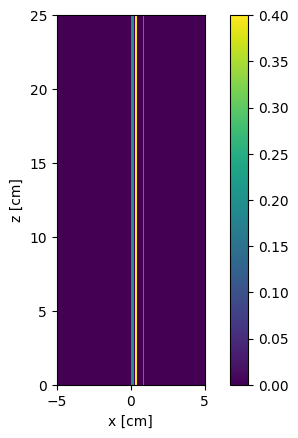

(100, 100, 1)
[ 0.1  0.1 25. ]


/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


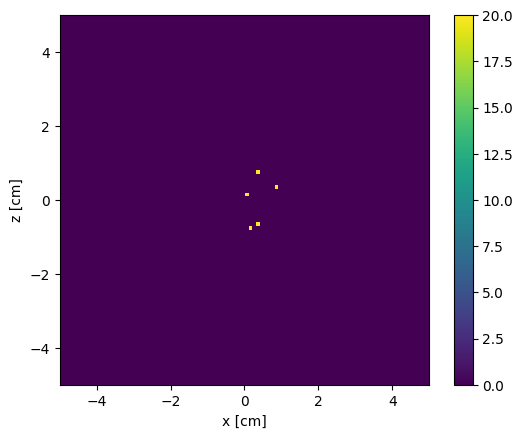

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(1, 100, 500)
[10.    0.1   0.05]


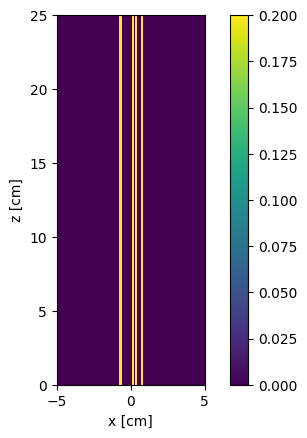

mesh 3           particle nuclide score     mean
           x    y    z                                
0          1    1    1  neutron   total  flux 0.00e+00
1          1    2    1  neutron   total  flux 0.00e+00
2          1    3    1  neutron   total  flux 0.00e+00
3          1    4    1  neutron   total  flux 0.00e+00
4          1    5    1  neutron   total  flux 0.00e+00
...      ...  ...  ...      ...     ...   ...      ...
49995      1   96  500  neutron   total  flux 0.00e+00
49996      1   97  500  neutron   total  flux 0.00e+00
49997      1   98  500  neutron   total  flux 0.00e+00
49998      1   99  500  neutron   total  flux 0.00e+00
49999      1  100  500  neutron   total  flux 0.00e+00

[50000 rows x 7 columns]

In [12]:
sp = openmc.StatePoint("statepoint.1.h5")
tally_vacio_xy  = sp.get_tally(name='vacio_xy')
tally_vacio_xz  = sp.get_tally(name='vacio_xz')
tally_vacio_yz  = sp.get_tally(name='vacio_yz')
get_df_NormVolum(tally_vacio_xz,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_xy,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_yz,Plot=True,ylabel='z [cm]')


In [13]:
Plano_1 = kds.surfsource.SurfaceSourceFile('surface_source.mcpl') 
plist_1 = kds.PList("surface_source.mcpl")
geometry_1 = kds.Geometry([kds.geom.SurfXY(xmin=-L,xmax=L,ymin=-L,ymax=L)])
S_1 = kds.KDSource(plist_1,geometry_1)

Number of particles in file surface_source.mcpl: 5
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Using existing file surface_source.mcpl
sum_weights = 5.0
p2 = 5.0
N = 5
N_eff = 5.0


In [14]:
var_importance = [1,1]

parts,ws = S_1.plist.get(N=-1)
scaling = S_1.geom.std(parts=parts)
scaling /= var_importance

# Number of particles to use for optimization.
# A large number (1E5 or more) gives better bandwidths, but takes longer to
# compute.
N = 1

In [15]:
S_1.bw_method = "silv"
S_1.fit(N, scaling=scaling)


Using 1 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.28906124 0.56977059]]


In [16]:
xmlfile = "Source_1.xml"
S_1.save(xmlfile)



##tengo que generar source desde kde

Successfully saved parameters file Source_1.xml


'Source_1.xml'

In [17]:
#Numero de particulas 
N = int(13)
param_resampled = openmc.Settings()
# param.surface = openmc.Settings.surf_source_read('Source_1.xml')

param_resampled.source = openmc.KernelDensitySource('Source_1.xml')
param_resampled.run_mode = "fixed source"
param_resampled.batches = 5
param_resampled.particles = N

superficies = [surf8.id]

param_resampled.surf_source_write = {
    'surface_ids': superficies,
    'max_particles': len(superficies)*N,
    'mcpl':False
}


# Bueno aca no estoy muy seguro de como seguir, mis opciones son ir por lo que escribi y ver como pasar el archivo xml al cpp de openmc, al FILESOURCE

In [18]:
tallies_resampled = openmc.Tallies()


#FILTRO PARTICULA
Filtro_particula_neutron_resampled = openmc.ParticleFilter(['neutron'],filter_id = 0)

#GRILLA

mesh_vacio_xy_resampled = openmc.RegularMesh.from_domain(domain=cell02,dimension=(100,100,1),mesh_id=1)
mesh_vacio_xy_resampled.lower_left = [-L, -L, alpha*L]
mesh_vacio_xy_resampled.upper_rigth = [L, L, 2*alpha*L]

mesh_vacio_xz_resampled = openmc.RegularMesh.from_domain(domain=cell02,dimension=(100,1,500),mesh_id=2)
mesh_vacio_xz_resampled.lower_left = [-L, -L, alpha*L]
mesh_vacio_xy_resampled.upper_rigth = [L, L, 2*alpha*L]

mesh_vacio_yz_resampled = openmc.RegularMesh.from_domain(domain=cell02,dimension=(1,100,500),mesh_id=3)
mesh_vacio_yz_resampled.lower_left = [-L, -L, alpha*L]
mesh_vacio_yz_resampled.upper_rigth = [L, L, 2*alpha*L]

#FILTRO ESPACIAL

filt_vacio_xy_resampled = openmc.filter.MeshFilter(mesh_vacio_xy_resampled,filter_id=1)
filt_vacio_xz_resampled = openmc.filter.MeshFilter(mesh_vacio_xz_resampled,filter_id=2)
filt_vacio_yz_resampled = openmc.filter.MeshFilter(mesh_vacio_yz_resampled,filter_id=3)


#Tallys

dist_vacio_xy_resampled = openmc.Tally(name='vacio_xy' , tally_id=1)
dist_vacio_xy_resampled.scores = ["flux"]
dist_vacio_xy_resampled.filters = [filt_vacio_xy_resampled, Filtro_particula_neutron_resampled]
tallies_resampled.append(dist_vacio_xy_resampled)

dist_vacio_xz_resampled = openmc.Tally(name='vacio_xz' , tally_id=2)
dist_vacio_xz_resampled.scores = ["flux"]
dist_vacio_xz_resampled.filters = [filt_vacio_xz_resampled, Filtro_particula_neutron_resampled]
tallies_resampled.append(dist_vacio_xz_resampled)

dist_vacio_yz_resampled = openmc.Tally(name='vacio_yz' , tally_id=3)
dist_vacio_yz_resampled.scores = ["flux"]
dist_vacio_yz_resampled.filters = [filt_vacio_yz_resampled, Filtro_particula_neutron_resampled]
tallies_resampled.append(dist_vacio_yz_resampled)



/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=0.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=2.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=3.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70

In [19]:
!rm geometry.xml
!rm materials.xml
!rm settings.xml
!rm tallies.xml

geom = openmc.Geometry(univ01)
geom.export_to_xml()
mats = openmc.Materials(univ01.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()


param_resampled.export_to_xml()

tallies_resampled.export_to_xml()

In [20]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run(threads=1)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

(100, 1, 500)
[ 0.1  10.    0.05]


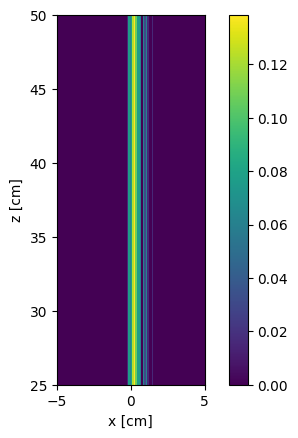

(100, 100, 1)
[ 0.1  0.1 25. ]


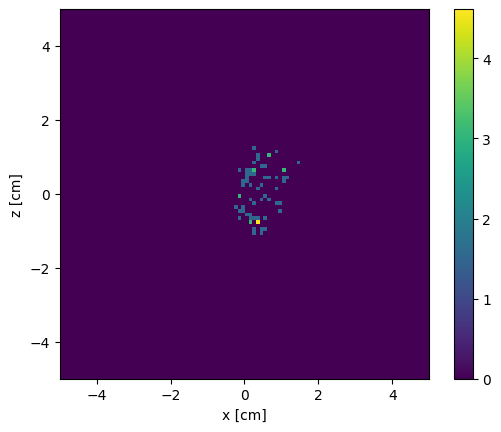

(1, 100, 500)
[10.    0.1   0.05]


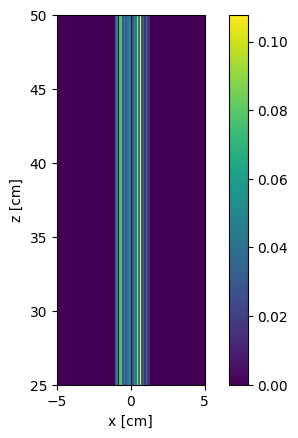

mesh 3           particle nuclide score     mean std. dev.
           x    y    z                                          
0          1    1    1  neutron   total  flux 0.00e+00  0.00e+00
1          1    2    1  neutron   total  flux 0.00e+00  0.00e+00
2          1    3    1  neutron   total  flux 0.00e+00  0.00e+00
3          1    4    1  neutron   total  flux 0.00e+00  0.00e+00
4          1    5    1  neutron   total  flux 0.00e+00  0.00e+00
...      ...  ...  ...      ...     ...   ...      ...       ...
49995      1   96  500  neutron   total  flux 0.00e+00  0.00e+00
49996      1   97  500  neutron   total  flux 0.00e+00  0.00e+00
49997      1   98  500  neutron   total  flux 0.00e+00  0.00e+00
49998      1   99  500  neutron   total  flux 0.00e+00  0.00e+00
49999      1  100  500  neutron   total  flux 0.00e+00  0.00e+00

[50000 rows x 8 columns]

In [21]:
sp_resampled = openmc.StatePoint("statepoint.5.h5")
tally_vacio_xy_resampled  = sp_resampled.get_tally(name='vacio_xy')
tally_vacio_xz_resampled  = sp_resampled.get_tally(name='vacio_xz')
tally_vacio_yz_resampled  = sp_resampled.get_tally(name='vacio_yz')
get_df_NormVolum(tally_vacio_xz_resampled,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_xy_resampled,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_yz_resampled,Plot=True,ylabel='z [cm]')

In [22]:
Plano_1.get_pandas_dataframe()


,id,type,E,x,y,z,u,v,w,t,...,pz,userflags,R,theta,mu,psi,phi,ln(E0/E),log(t),lambda
0,0,2112.0,0.00003,0.063117,0.113411,25.0,0.0,0.0,1.0,0.0033,...,0.0,0.0,0.129791,1.062951,1.0,0.0,0.0,13.410045,-2.481493,0.052219
1,1,2112.0,0.00003,0.166825,-0.705006,25.0,0.0,0.0,1.0,0.0033,...,0.0,0.0,0.724475,-1.338441,1.0,0.0,0.0,13.410045,-2.481493,0.052219
2,2,2112.0,0.00003,0.333041,0.759236,25.0,0.0,0.0,1.0,0.0033,...,0.0,0.0,0.829069,1.157419,1.0,0.0,0.0,13.410045,-2.481493,0.052219
3,3,2112.0,0.00003,0.322191,-0.630884,25.0,0.0,0.0,1.0,0.0033,...,0.0,0.0,0.708394,-1.098628,1.0,0.0,0.0,13.410045,-2.481493,0.052219
4,4,2112.0,0.00003,0.898722,0.374714,25.0,0.0,0.0,1.0,0.0033,...,0.0,0.0,0.973710,0.395024,1.0,0.0,0.0,13.410045,-2.481493,0.052219


In [23]:
Plano_1_resampled = kds.surfsource.SurfaceSourceFile('surface_source.h5')
Plano_1_resampled.get_pandas_dataframe()

Number of particles in file surface_source.h5: 13
100% n, 0% g, 0% e-, 0% e+, 0% p, 


,id,type,E,x,y,z,u,v,w,t,...,pz,userflags,R,theta,mu,psi,phi,ln(E0/E),log(t),lambda
0,0,2112,0.00003,-0.039649,0.204720,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,0.208524,1.762101,1.0,0.0,0.0,13.410045,-2.180463,0.052219
1,1,2112,0.00003,0.197594,-0.631380,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,0.661577,-1.267497,1.0,0.0,0.0,13.410045,-2.180463,0.052219
2,2,2112,0.00003,-0.000624,0.393790,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,0.393791,1.572382,1.0,0.0,0.0,13.410045,-2.180463,0.052219
3,3,2112,0.00003,0.009370,-0.513021,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,0.513107,-1.552534,1.0,0.0,0.0,13.410045,-2.180463,0.052219
4,4,2112,0.00003,0.855791,-0.299434,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,0.906663,-0.336578,1.0,0.0,0.0,13.410045,-2.180463,0.052219
5,5,2112,0.00003,0.091455,0.403340,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,0.413579,1.347821,1.0,0.0,0.0,13.410045,-2.180463,0.052219
6,6,2112,0.00003,-0.178980,-0.022386,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,0.180374,-3.017162,1.0,0.0,0.0,13.410045,-2.180463,0.052219
7,7,2112,0.00003,0.335073,1.026638,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,1.079935,1.255318,1.0,0.0,0.0,13.410045,-2.180463,0.052219
8,8,2112,0.00003,0.259780,-1.039493,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,1.071462,-1.325902,1.0,0.0,0.0,13.410045,-2.180463,0.052219
9,9,2112,0.00003,1.157571,0.466118,50.0,0.0,0.0,1.0,0.0066,...,0.0,0,1.247893,0.382805,1.0,0.0,0.0,13.410045,-2.180463,0.052219


In [24]:
Plano_1_resampled.get_pandas_dataframe()['y'].value_counts()


y
 0.204720    1
-0.631380    1
 0.393790    1
-0.513021    1
-0.299434    1
 0.403340    1
-0.022386    1
 1.026638    1
-1.039493    1
 0.466118    1
 0.571342    1
-0.456327    1
 1.182684    1
Name: count, dtype: int64